In [1]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, AveragePooling1D, LSTM, Reshape,RNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import random

# Functions

### Function to plot series

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

### Functions to Normalize and Denormalize the time series

In [3]:
# Normalize the time series
def normalize_time_series_numpy(T, scale = 100):
    """
    Normalize a time series numpy array using min-max scaling.
    
    Args:
        T (numpy.ndarray): A numpy array of the form [[t1,v1],[t2,v2],[t3,v3],...]
        
    Returns:
        numpy.ndarray: A normalized numpy array of the same form as T
    """
    # Extract the values from the numpy array
    values = T[:, 1]
    
    # Find the minimum and maximum values in the time series
    min_val = np.min(values)
    max_val = np.max(values)
    
    # Apply min-max scaling to each value in the time series
    normalized_values = (values - min_val) / (max_val - min_val)
    
    # Scaling the values to scale
    normalized_values *= scale
    
    # Create a new numpy array with the normalized values
    normalized_T = np.column_stack((T[:, 0], normalized_values))
    
    return normalized_T, min_val, max_val

In [4]:
# Denormalize the time series
def denormalize_time_series_numpy(normalized_T, original_min, original_max, scale):
    """
    Denormalize a time series numpy array that has been normalized using min-max scaling.
    
    Args:
        normalized_T (numpy.ndarray): A numpy array of the form [[t1,v1],[t2,v2],[t3,v3],...] containing normalized values
        original_min (float): The minimum value of the original time series
        original_max (float): The maximum value of the original time series
        
    Returns:
        numpy.ndarray: A denormalized numpy array of the same form as normalized_T
    """
    # Extract the normalized values from the numpy array
    normalized_values = normalized_T[:, 1]
    
    # Apply the reverse min-max scaling formula to each value in the normalized time series
    normalized_values /= scale
    denormalized_values = (normalized_values * (original_max - original_min)) + original_min
    
    # Create a new numpy array with the denormalized values
    denormalized_T = np.column_stack((normalized_T[:, 0], denormalized_values))
    
    return denormalized_T


## Functions to create the model and adjust learning rate

In [5]:
def adjust_learning_rate(optimize = 'adam'):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-12 * 10**(epoch / 25))
    
    # Select your optimizer
    if optimize == 'adam':
        optimizer = Adam(learning_rate=1e-3)
    else:
        optimizer = tf.keras.optimizers.SGD(momentum = 0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss= tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    # Create the LearningRateScheduler callback with the schedule function
#     lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

    # Train the model using the callback
    history = model.fit(X, y, epochs=300, callbacks=[lr_schedule])
    
    return history

In [6]:
def create_uncompiled_model(summary = False):

    
    # Define the CNN model
    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(n_train, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
#     model.add(Reshape((model.layers[-1].output_shape[1], 1))) # Reshape for input to LSTM
#     model.add(LSTM(32))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(1))
    
    if summary:
        model.summary()
    
    return model

In [7]:
def create_model(loss = 'mse',lr = 1e-5, optimize = 'adam'):

    tf.random.set_seed(51)
    loss = tf.keras.losses.Huber()
    
    model = create_uncompiled_model()
    if optimize == 'adam':
        op = Adam(learning_rate = lr)
    else:
        op = tf.keras.optimizers.SGD(momentum = 0.9,learning_rate = lr)
    

    model.compile(loss=loss,
                  optimizer=op,
                  metrics=["mae"])  
    

    return model

# Data set

In [8]:
df = pd.read_csv('Data.csv')

In [9]:
df.shape

(34, 14)

In [10]:
df = df.dropna()

In [11]:
df.shape

(32, 14)

In [12]:
cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
       'OCT', 'NOV', 'DEC']
fd = df[cols]
values = fd.values.flatten().tolist()
values.reverse()

### Original Time Sereis

In [13]:
Original_T = []
for i,val in enumerate(values):
    Original_T.append((int(i+1),int(val)))
Original_T = np.array(Original_T)

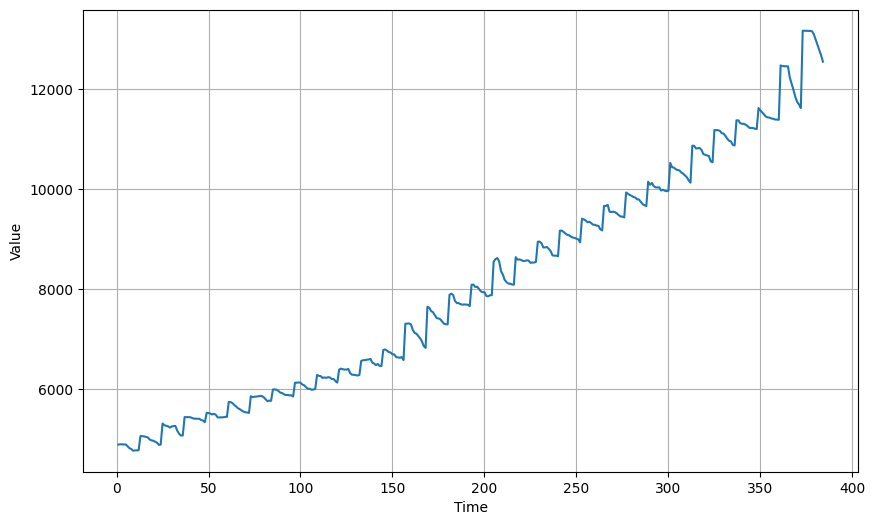

In [14]:
f = 0.3
s = int(Original_T.shape[0]*f)
e = int(Original_T.shape[0]*(f+0.2))
plot_series(Original_T[:,0],Original_T[:,1])

### Normalized Time Series

In [15]:
# The scale to normalize the data to
scale = 10

normalized_T, min_val, max_val = normalize_time_series_numpy(Original_T, scale = scale)
T = normalized_T

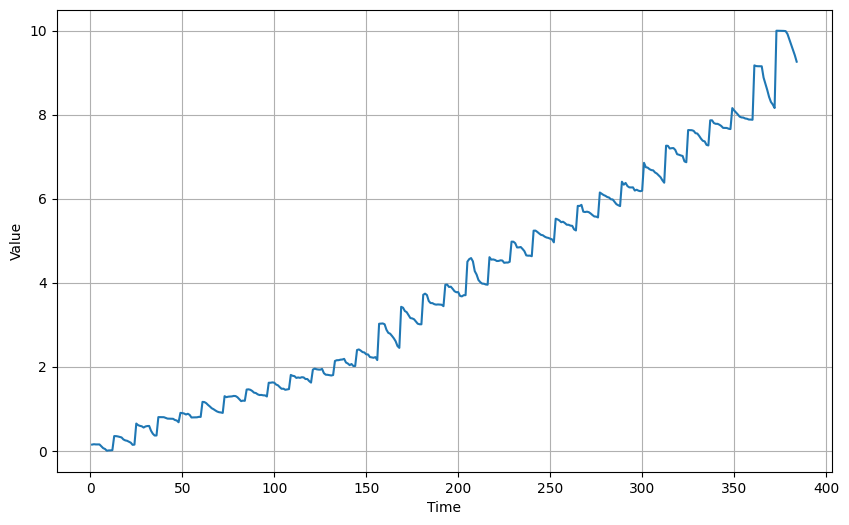

In [16]:
f = 0.3
s = int(T.shape[0]*f)
e = int(T.shape[0]*(f+0.2))
plot_series(T[:,0],T[:,1])

# Functions for DVS

## Function for calculating errors

In [17]:
# Errors

def calculate_errors(y_true, y_pred):
    N = y_pred.shape[0]
    
    # Mean Absolute Difference (MAD)
    mad = np.mean(np.abs(y_pred - y_true))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100
    
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean(np.square(y_pred - y_true)))
    
    # Normalized Root Mean Squared Error (NRMSE)
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    
    return mad, mape, smape, rmse, nrmse

## Function for visual(Ti,Tj)

In [18]:
# visual relationship

def visual_relationship(T, i, j):
    """
    Calculates the visual relationship between nodes i and j in a time series T.

    Args:
        T (array-like): The time series.
        i (int): The index of the first node.
        j (int): The index of the second node.

    Returns:
        int: If nodes i and j are visible, returns 1. Otherwise, returns 0.
    """

    # Calculate the slope between nodes i and j
    slope_i_j = (T[j][1] - T[i][1]) / (j - i)

    # Calculate the slopes between node i and each node between i and j
    slopes_i_theta = ((T[i+1:j+1,1] - T[i][1]) / (np.arange(j-i)+1)).reshape(-1,1)

    # Find the index of the maximum slope between node i and each node between i and j
    max_slope_idx = np.max(slopes_i_theta)

    # If the index of the maximum slope is equal to i, return 1. Otherwise, return 0.
    if max_slope_idx == slope_i_j:
        return 1
    else:
        return 0

## Function for visual matrix A

In [19]:
# visual matrix

def visual_matrix(T):
    """
    Calculates the visual matrix A for the time series T.

    Args:
        T (array-like): The time series.

    Returns:
        ndarray: The visual matrix A.
    """

    n = T.shape[0]
    A = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(i+1, n):
            A[i][j] = visual_relationship(T, i, j)
            A[j][i] = A[i][j]


    return A

## Function for enhanced visibility matrix B

In [20]:
# Enhanced visibility graph

def enhanced_visibility_graph(T, A):
    """
    Calculates the enhanced visibility graph (EVG) for the time series T and its visual matrix A.

    Args:
        T (ndarray): The time series, where each row is of the form (time, value).
        A (ndarray): The visual matrix A for the time series.

    Returns:
        ndarray: The enhanced adjacency matrix B.
    """

    n = T.shape[0]
    B = np.zeros((n, n))

    for i in range(n):
        degree = np.sum(A[i])
        for j in range(n):
            if A[i][j] == 1:
                B[i][j] = (A[i][j] * T[j][1]) / degree

    return B

## Function for compressed EVG

In [21]:
# Compressed Series

def compress_evg(B):
    """
    Compresses the enhanced adjacency matrix B generated by the EVG algorithm to generate a Deep Visibility Series (DVS) module.

    Args:
        B (ndarray): The enhanced adjacency matrix B.

    Returns:
        ndarray: The compressed DVS sequence.
    """

    n = B.shape[0]
    zip = np.zeros(n)

    for i in range(n):
        zip[i] = np.sum(B[:,i])

    return zip

## Calculating zip

In [22]:
"""
Uses the Deep Visibility Series (DVS) module to forecast the value of the next time point in the time series T.

Args:
    T (ndarray): The time series, where each row is of the form (time, value).
    v (ndarray): The array of values in the time series T.
    n_train (int): The number of time points to use for training the NN.
    n_test (int): The number of time points to use for testing the prediction.

Returns:
    float: The predicted value of the next time point in the time series T.
"""

# Calculate the visual matrix A
A = visual_matrix(T)

# Calculate the enhanced adjacency matrix B
B = enhanced_visibility_graph(T, A)

# Compress the matrix B to generate the DVS sequence
zip = compress_evg(B)

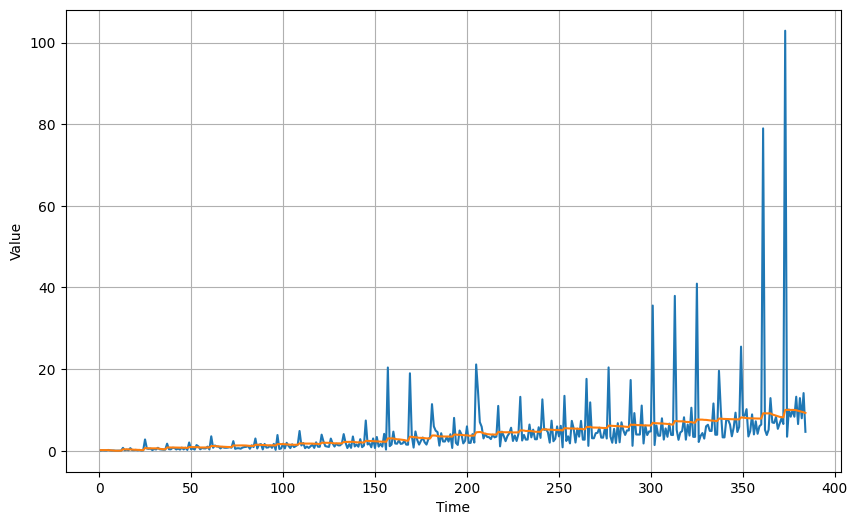

In [23]:
f = 0.3
s = int(zip.shape[0]*f)
e = int(zip.shape[0]*(f+0.2))
plt.figure(figsize=(10, 6))
plt.plot(T[:,0],zip)
plt.plot(T[:,0],T[:,1])

# Label the x-axis
plt.xlabel("Time")

# Label the y-axis
plt.ylabel("Value")

# Overlay a grid on the graph
plt.grid(True)

# Draw the graph on screen
plt.show()

### Defining n_train and n_test

In [24]:
# Self-made parameters
a = 0.8
b = 0.2

# Defining n_train and n_test
n_train = int(zip.shape[0]*a)
n_test = int(zip.shape[0]*b)

## Making the vectors X and y for training and prediction

In [25]:
# Prepare the input and output data for training the CNN
X = []
y = []
for i in range(n_train, zip.shape[0] - n_test):
    X.append(zip[i-n_train:i])
    y.append(T[i-n_train:i,1])
#     y.append(T[i+n_test, 1])

# Convert the data to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape the input data to match the expected shape of the CNN
X = X.reshape((X.shape[0], X.shape[1], 1))

In [26]:
X.shape

(1, 307, 1)

In [27]:
y.shape

(1, 307)

## Creating and compiling the model

### Testing the compilation

In [28]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model(summary = True)

try:
    uncompiled_model.predict(X)
except:
    print("Your current architecture is incompatible with the zip dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the zip dataset! :)")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 305, 8)            32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 16)           400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 100)               1

### Finding the best learning rate

In [29]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 1.4288 - mae: 1.8544 - lr: 1.0000e-12
Epoch 2/300
1/1 [==============================] - 0s 15ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.0965e-12
Epoch 3/300
1/1 [==============================] - 0s 12ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.2023e-12
Epoch 4/300
1/1 [==============================] - 0s 13ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.3183e-12
Epoch 5/300
1/1 [==============================] - 0s 16ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.4454e-12
Epoch 6/300
1/1 [==============================] - 0s 17ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.5849e-12
Epoch 7/300
1/1 [==============================] - 0s 18ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.7378e-12
Epoch 8/300
1/1 [==============================] - 0s 19ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.9055e-12
Epoch 9/300
1/1 [==============================] - 0s 18ms/step - loss: 1.4288 - mae: 1.8544 - lr: 2.0893e-12
Epoch 10/300

Epoch 75/300
1/1 [==============================] - 0s 15ms/step - loss: 1.4288 - mae: 1.8544 - lr: 9.1201e-10
Epoch 76/300
1/1 [==============================] - 0s 14ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.0000e-09
Epoch 77/300
1/1 [==============================] - 0s 13ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.0965e-09
Epoch 78/300
1/1 [==============================] - 0s 14ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.2023e-09
Epoch 79/300
1/1 [==============================] - 0s 16ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.3183e-09
Epoch 80/300
1/1 [==============================] - 0s 18ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.4454e-09
Epoch 81/300
1/1 [==============================] - 0s 18ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.5849e-09
Epoch 82/300
1/1 [==============================] - 0s 17ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.7378e-09
Epoch 83/300
1/1 [==============================] - 0s 21ms/step - loss: 1.4288 - mae: 1.8544 - lr: 1.9055e-09
E

1/1 [==============================] - 0s 14ms/step - loss: 1.4205 - mae: 1.8464 - lr: 7.5858e-07
Epoch 149/300
1/1 [==============================] - 0s 11ms/step - loss: 1.4197 - mae: 1.8457 - lr: 8.3176e-07
Epoch 150/300
1/1 [==============================] - 0s 11ms/step - loss: 1.4188 - mae: 1.8449 - lr: 9.1201e-07
Epoch 151/300
1/1 [==============================] - 0s 11ms/step - loss: 1.4179 - mae: 1.8440 - lr: 1.0000e-06
Epoch 152/300
1/1 [==============================] - 0s 11ms/step - loss: 1.4169 - mae: 1.8431 - lr: 1.0965e-06
Epoch 153/300
1/1 [==============================] - 0s 12ms/step - loss: 1.4158 - mae: 1.8420 - lr: 1.2023e-06
Epoch 154/300
1/1 [==============================] - 0s 12ms/step - loss: 1.4146 - mae: 1.8409 - lr: 1.3183e-06
Epoch 155/300
1/1 [==============================] - 0s 14ms/step - loss: 1.4133 - mae: 1.8396 - lr: 1.4454e-06
Epoch 156/300
1/1 [==============================] - 0s 13ms/step - loss: 1.4119 - mae: 1.8383 - lr: 1.5849e-06
Epoch 

1/1 [==============================] - 0s 16ms/step - loss: 1.2816 - mae: 1.7512 - lr: 6.3096e-04
Epoch 222/300
1/1 [==============================] - 0s 13ms/step - loss: 1.2836 - mae: 1.7536 - lr: 6.9183e-04
Epoch 223/300
1/1 [==============================] - 0s 15ms/step - loss: 1.2846 - mae: 1.7547 - lr: 7.5858e-04
Epoch 224/300
1/1 [==============================] - 0s 15ms/step - loss: 1.2837 - mae: 1.7538 - lr: 8.3176e-04
Epoch 225/300
1/1 [==============================] - 0s 16ms/step - loss: 1.2817 - mae: 1.7513 - lr: 9.1201e-04
Epoch 226/300
1/1 [==============================] - 0s 15ms/step - loss: 1.2802 - mae: 1.7482 - lr: 0.0010
Epoch 227/300
1/1 [==============================] - 0s 14ms/step - loss: 1.2807 - mae: 1.7455 - lr: 0.0011
Epoch 228/300
1/1 [==============================] - 0s 16ms/step - loss: 1.2825 - mae: 1.7438 - lr: 0.0012
Epoch 229/300
1/1 [==============================] - 0s 15ms/step - loss: 1.2833 - mae: 1.7435 - lr: 0.0013
Epoch 230/300
1/1 [===

1/1 [==============================] - 0s 15ms/step - loss: 1.3273 - mae: 1.7923 - lr: 0.6310
Epoch 297/300
1/1 [==============================] - 0s 12ms/step - loss: 1.3674 - mae: 1.8274 - lr: 0.6918
Epoch 298/300
1/1 [==============================] - 0s 13ms/step - loss: 1.2833 - mae: 1.7533 - lr: 0.7586
Epoch 299/300
1/1 [==============================] - 0s 13ms/step - loss: 1.3358 - mae: 1.7719 - lr: 0.8318
Epoch 300/300
1/1 [==============================] - 0s 15ms/step - loss: 1.3211 - mae: 1.7607 - lr: 0.9120


(1e-12, 200.0, 0.0, 100.0)

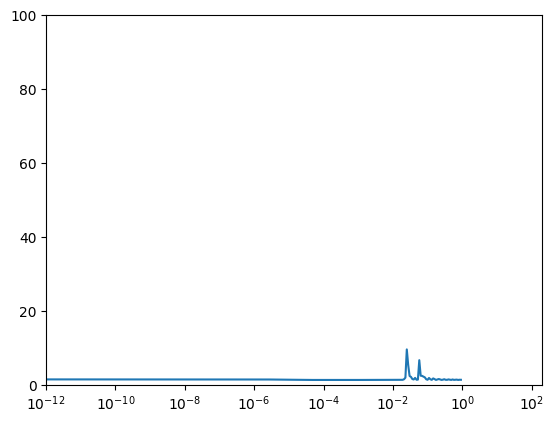

In [30]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-12, 200, 0, scale**2])

In [31]:
l=lr_history.history["lr"][lr_history.history["loss"].index(min(lr_history.history["loss"]))]
l

0.00022908677

### Train the model

In [32]:
# Save an instance of the model
model = create_model(lr = l)

# Train it
history = model.fit(X,y, epochs=200)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 2.0601 - mae: 2.5014
Epoch 2/200
1/1 [==============================] - 0s 21ms/step - loss: 1.5792 - mae: 2.0026
Epoch 3/200
1/1 [==============================] - 0s 15ms/step - loss: 1.3442 - mae: 1.7783
Epoch 4/200
1/1 [==============================] - 0s 16ms/step - loss: 1.2814 - mae: 1.7446
Epoch 5/200
1/1 [==============================] - 0s 19ms/step - loss: 1.2951 - mae: 1.7642
Epoch 6/200
1/1 [==============================] - 0s 18ms/step - loss: 1.3384 - mae: 1.8024
Epoch 7/200
1/1 [==============================] - 0s 15ms/step - loss: 1.3781 - mae: 1.8368
Epoch 8/200
1/1 [==============================] - 0s 21ms/step - loss: 1.3996 - mae: 1.8587
Epoch 9/200
1/1 [==============================] - 0s 18ms/step - loss: 1.4022 - mae: 1.8613
Epoch 10/200
1/1 [==============================] - 0s 17ms/step - loss: 1.3892 - mae: 1.8481
Epoch 11/200
1/1 [==============================] - 0s 19ms/step - loss

1/1 [==============================] - 0s 19ms/step - loss: 1.2801 - mae: 1.7474
Epoch 89/200
1/1 [==============================] - 0s 17ms/step - loss: 1.2801 - mae: 1.7476
Epoch 90/200
1/1 [==============================] - 0s 15ms/step - loss: 1.2801 - mae: 1.7477
Epoch 91/200
1/1 [==============================] - 0s 18ms/step - loss: 1.2801 - mae: 1.7477
Epoch 92/200
1/1 [==============================] - 0s 16ms/step - loss: 1.2801 - mae: 1.7477
Epoch 93/200
1/1 [==============================] - 0s 16ms/step - loss: 1.2801 - mae: 1.7477
Epoch 94/200
1/1 [==============================] - 0s 12ms/step - loss: 1.2801 - mae: 1.7477
Epoch 95/200
1/1 [==============================] - 0s 16ms/step - loss: 1.2801 - mae: 1.7476
Epoch 96/200
1/1 [==============================] - 0s 15ms/step - loss: 1.2801 - mae: 1.7475
Epoch 97/200
1/1 [==============================] - 0s 16ms/step - loss: 1.2801 - mae: 1.7474
Epoch 98/200
1/1 [==============================] - 0s 14ms/step - loss: 

1/1 [==============================] - 0s 12ms/step - loss: 1.2801 - mae: 1.7474
Epoch 175/200
1/1 [==============================] - 0s 13ms/step - loss: 1.2801 - mae: 1.7474
Epoch 176/200
1/1 [==============================] - 0s 13ms/step - loss: 1.2801 - mae: 1.7474
Epoch 177/200
1/1 [==============================] - 0s 12ms/step - loss: 1.2801 - mae: 1.7474
Epoch 178/200
1/1 [==============================] - 0s 10ms/step - loss: 1.2801 - mae: 1.7474
Epoch 179/200
1/1 [==============================] - 0s 10ms/step - loss: 1.2801 - mae: 1.7474
Epoch 180/200
1/1 [==============================] - 0s 11ms/step - loss: 1.2801 - mae: 1.7474
Epoch 181/200
1/1 [==============================] - 0s 11ms/step - loss: 1.2801 - mae: 1.7474
Epoch 182/200
1/1 [==============================] - 0s 12ms/step - loss: 1.2801 - mae: 1.7474
Epoch 183/200
1/1 [==============================] - 0s 14ms/step - loss: 1.2801 - mae: 1.7474
Epoch 184/200
1/1 [==============================] - 0s 16ms/ste

### Model predict

In [33]:
# # Prepare the input data for making the prediction
# input_data = zip[-n_train:].reshape((1, n_train, 1))
# # Make the prediction and return the result
# y = model.predict(input_data)[0]

In [34]:
k = n_test
y_pred = []
for i in range(k):
    # Prepare the input data for making the prediction
    input_data = zip[-n_train-k+i:-k+i].reshape((1, n_train, 1))
    # Make the prediction and return the result
    y_pred.append(model.predict(input_data)[0])
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 42ms/step


### Plot

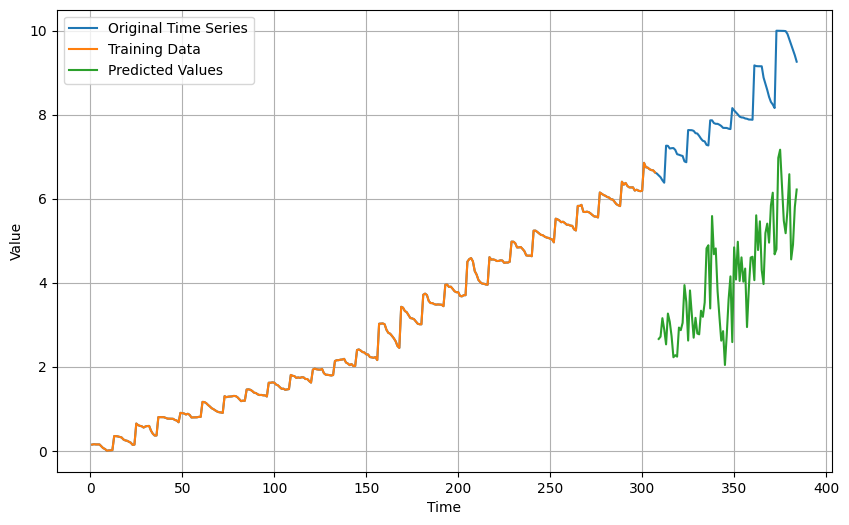

In [35]:
# Setup dimensions of the graph figure
plt.figure(figsize=(10, 6))

# Plot the original time series
plt.plot(T[:, 0], T[:, 1], label='Original Time Series')

# Plot the training data
plt.plot(T[:n_train, 0], T[:n_train, 1], label='Training Data')

# Plot the predicted values
plt.plot(T[-n_test:, 0], y_pred, label='Predicted Values')

# Label the x-axis
plt.xlabel("Time")

# Label the y-axis
plt.ylabel("Value")

# Add a legend
plt.legend()

# Overlay a grid on the graph
plt.grid(True)

# Draw the graph on screen
plt.show()

### Errors

In [36]:
# Calculate the errors
y_true = T[-n_test:,1]
mad, mape, smape, rmse, nrmse = calculate_errors(y_true, y_pred)

# Print the errors
print("Mean Absolute Difference (MAD):", mad)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)
print("Root Mean Square Error (RMSE):", rmse)
print("Normalized Root Mean Squared Error (NRMSE):", nrmse)

Mean Absolute Difference (MAD): 3.9785412375327223
Mean Absolute Percentage Error (MAPE): 48.69035799686342
Symmetric Mean Absolute Percentage Error (SMAPE): 67.51218560584033
Root Mean Square Error (RMSE): 4.279537464665706
Normalized Root Mean Squared Error (NRMSE): 1.1826036983363102
